<a href="https://colab.research.google.com/github/Hoang2531992/Attendance_Visitor_Monitoring_Webapp/blob/main/Segmentation_indoor_B7_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm
#!pip install --upgrade pip
# !pip install -q segmentation-models-pytorch
#!pip install -q torchsummary

from torchsummary import summary
# import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
IMAGE_PATH = '/content/gdrive/MyDrive/1_segmentation_indoor/nyuv2-python-toolkit-master/NYUv2/image/images/'
MASK_PATH = '/content/gdrive/MyDrive/1_segmentation_indoor/nyuv2-python-toolkit-master/NYUv2/seg13/masks/'

In [6]:
n_classes = 14

def create_df(IMAGE_PATH):
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])

    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

In [7]:
df = create_df(IMAGE_PATH)
print('Total Images: ', len(df))

Total Images:  1449


In [8]:
#split data
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  1108
Val Size     :  196
Test Size    :  145


In [9]:
def deformat_mask(mask):
    mask[mask==255]=13
    return mask

In [10]:
import os
import cv2

# Đường dẫn đến thư mục chứa ảnh
image_dir = '/content/gdrive/MyDrive/1_segmentation_indoor/nyuv2-python-toolkit-master/NYUv2/seg13/masks'
# Lấy danh sách các tệp ảnh trong thư mục
image_files = [f for f in os.listdir(image_dir) if f.split('.')[0] in (X_train) ]
pixel_list = []

# Lặp qua từng tệp ảnh
for image_file in image_files:
    pixel_per_image = []

    # Xây dựng đường dẫn tuyệt đối đến tệp ảnh
    image_path = os.path.join(image_dir, image_file)

    # Đọc ảnh từ tệp
    image = deformat_mask(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE))

    # Lấy kích thước ảnh
    for i in range(14):

        label = image==i
        label_per_class = np.sum(label)
    # Lặp qua từng pixel trong ảnh (giống như trong ví dụ trước)
        pixel_per_image.append(label_per_class)
    # for i in range(14):
    #   pixel_list[i]+=pixel_per_image[i]
    pixel_list.append(pixel_per_image)
pixel_per_class = np.sum(pixel_list, axis=0)
print(pixel_per_class)

[13016126  1876627  4159067 11921729 33728672 47277720 42359679  7200064
  9599153 10957934  1722676 80509479 17156399 58892275]


In [11]:
cd /content/gdrive/MyDrive/1_segmentation_indoor/segmentation_models.pytorch

/content/gdrive/MyDrive/1_segmentation_indoor/segmentation_models.pytorch


In [12]:
!pip install timm
!pip install pretrainedmodels
!pip install efficientnet-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 17.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylin

In [13]:
import segmentation_models_pytorch as smp

Image Size (480, 640, 3)
Mask Size (480, 640)


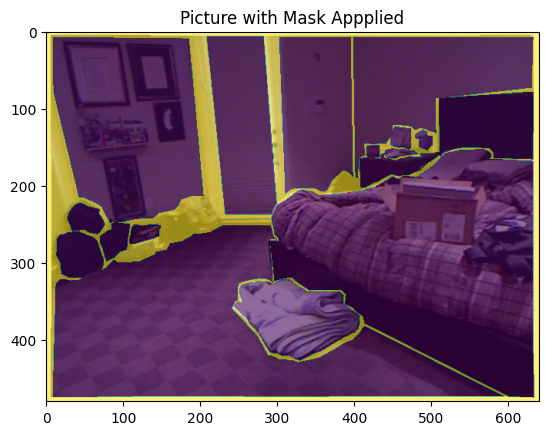

In [14]:
img = Image.open(IMAGE_PATH + df['id'][100] + '.png')
mask = Image.open(MASK_PATH + df['id'][100] + '.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

### **Dataset**

In [15]:
class DroneDataset(Dataset):

    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        mask = deformat_mask(mask)
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']

        if self.transform is None:
            img = Image.fromarray(img)

        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()

        if self.patches:
            img, mask = self.tiles(img, mask)

        return img, mask

    def tiles(self, img, mask):

        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768)
        img_patches  = img_patches.contiguous().view(3,-1, 512, 768)
        img_patches = img_patches.permute(1,0,2,3)

        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)

        return img_patches, mask_patches

In [16]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.HorizontalFlip(), A.VerticalFlip(),
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

#datasets
train_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, transform=t_train, patch=False)
val_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, transform=t_val, patch=False)

#dataloader
batch_size= 2


train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

Model

In [28]:
model = smp.Unet('efficientnet-b7', encoder_weights='imagenet', classes=14, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16], decoder_attention_type="scse")

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth
100%|██████████| 254M/254M [00:00<00:00, 268MB/s]


In [29]:
# Training
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

def mIoU(pred_mask, mask, smooth=1e-10, n_classes=14):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1, c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)

            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            loss = criterion(output, mask)
            # loss = SegLossFn(output, mask)

            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight
            optimizer.zero_grad() #reset gradient

            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step()

            running_loss += loss.item()

        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1, c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)

                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)
                    # loss = SegLossFn(output, mask)
                    test_loss += loss.item()

            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-Efficient-b3_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))


            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    # break

            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))

    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [30]:
class_weights = []
for i in range(len(pixel_per_class)):
  class_weight = 1-(pixel_per_class[i] /  np.sum(pixel_per_class))
  class_weights.append(class_weight)
print(class_weights)

[0.9617597456471871, 0.9944866319052723, 0.9877810202551519, 0.9649749895410273, 0.900908073856799, 0.8611021406814079, 0.8755509205071074, 0.9788468336341757, 0.971798517293735, 0.9678065360352738, 0.9949389266508725, 0.7634701020278656, 0.9495959810516321, 0.8269795809124925]


In [31]:
class_weights = torch.tensor(class_weights,dtype=torch.float)

In [32]:
class_weights= class_weights.cuda()
class_weights

tensor([0.9618, 0.9945, 0.9878, 0.9650, 0.9009, 0.8611, 0.8756, 0.9788, 0.9718,
        0.9678, 0.9949, 0.7635, 0.9496, 0.8270], device='cuda:0')

In [33]:
from segmentation_models_pytorch.losses import DiceLoss, TverskyLoss
from segmentation_models_pytorch.losses.constants import MULTICLASS_MODE

In [34]:
from typing import Optional, Sequence

import torch
from torch import Tensor
from torch import nn
from torch.nn import functional as F


class FocalLoss(nn.Module):
    """ Focal Loss, as described in https://arxiv.org/abs/1708.02002.

    It is essentially an enhancement to cross entropy loss and is
    useful for classification tasks when there is a large class imbalance.
    x is expected to contain raw, unnormalized scores for each class.
    y is expected to contain class labels.

    Shape:
        - x: (batch_size, C) or (batch_size, C, d1, d2, ..., dK), K > 0.
        - y: (batch_size,) or (batch_size, d1, d2, ..., dK), K > 0.
    """

    def __init__(self,
                 alpha: Optional[Tensor] = None,
                 gamma: float = 2.,
                 beta: float = 0.5,
                 reduction: str = 'mean',
                 ignore_index: int = -100):
        """Constructor.

        Args:
            alpha (Tensor, optional): Weights for each class. Defaults to None.
            gamma (float, optional): A constant, as described in the paper.
                Defaults to 0.
            reduction (str, optional): 'mean', 'sum' or 'none'.
                Defaults to 'mean'.
            ignore_index (int, optional): class label to ignore.
                Defaults to -100.
        """
        if reduction not in ('mean', 'sum', 'none'):
            raise ValueError(
                'Reduction must be one of: "mean", "sum", "none".')

        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.beta = beta
        self.ignore_index = ignore_index
        self.reduction = reduction

        self.nll_loss = nn.NLLLoss(
            weight=alpha, reduction='none', ignore_index=ignore_index)
        self.dice_loss = DiceLoss(mode='multiclass')
    def __repr__(self):
        arg_keys = ['alpha', 'gamma', 'ignore_index', 'reduction']
        arg_vals = [self.__dict__[k] for k in arg_keys]
        arg_strs = [f'{k}={v!r}' for k, v in zip(arg_keys, arg_vals)]
        arg_str = ', '.join(arg_strs)
        return f'{type(self).__name__}({arg_str})'

    def forward(self, x: Tensor, y: Tensor) -> Tensor:
        x_org = x
        y_org = y
        if x.ndim > 2:
            # (N, C, d1, d2, ..., dK) --> (N * d1 * ... * dK, C)
            c = x.shape[1]
            x = x.permute(0, *range(2, x.ndim), 1).reshape(-1, c)
            # (N, d1, d2, ..., dK) --> (N * d1 * ... * dK,)
            y = y.view(-1)

        unignored_mask = y != self.ignore_index
        y = y[unignored_mask]
        if len(y) == 0:
            return torch.tensor(0.)
        x = x[unignored_mask]

        # compute weighted cross entropy term: -alpha * log(pt)
        # (alpha is already part of self.nll_loss)
        log_p = F.log_softmax(x, dim=-1)
        ce = self.nll_loss(log_p, y)

        # get true class column from each row
        all_rows = torch.arange(len(x))
        log_pt = log_p[all_rows, y]

        # compute focal term: (1 - pt)^gamma
        pt = log_pt.exp()
        focal_term = (1 - pt)**self.gamma

        dice = self.dice_loss(x_org, y_org)
        # the full loss: -alpha * ((1 - pt)^gamma) * log(pt)
        focal = focal_term * ce

        loss = self.beta*focal + self.beta*dice
        if self.reduction == 'mean':
            loss = loss.mean()
        elif self.reduction == 'sum':
            loss = loss.sum()

        return loss


def focal_loss(alpha: Optional[Sequence] = None,
               gamma: float = 2.,
               beta: float = 0.5,
               reduction: str = 'mean',
               ignore_index: int = -100,
               device='cpu',
               dtype=torch.float32) -> FocalLoss:
    """Factory function for FocalLoss.

    Args:
        alpha (Sequence, optional): Weights for each class. Will be converted
            to a Tensor if not None. Defaults to None.
        gamma (float, optional): A constant, as described in the paper.
            Defaults to 0.
        reduction (str, optional): 'mean', 'sum' or 'none'.
            Defaults to 'mean'.
        ignore_index (int, optional): class label to ignore.
            Defaults to -100.
        device (str, optional): Device to move alpha to. Defaults to 'cpu'.
        dtype (torch.dtype, optional): dtype to cast alpha to.
            Defaults to torch.float32.

    Returns:
        A FocalLoss object
    """
    if alpha is not None:
        if not isinstance(alpha, Tensor):
            alpha = torch.tensor(alpha)
        alpha = alpha.to(device=device, dtype=dtype)

    fl = FocalLoss(
        alpha=alpha,
        gamma=gamma,
        beta=beta,
        reduction=reduction,
        ignore_index=ignore_index)
    return fl

In [35]:
# criterion = focal_loss(alpha=class_weights, device=device)
criterion = focal_loss(alpha=class_weights, device=device)

# criterion = nn.CrossEntropyLoss(reduction='mean')

In [36]:
max_lr = 1e-3
epoch = 20
weight_decay = 1e-4

# criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

  0%|          | 0/554 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 0.748 
Epoch:1/20.. Train Loss: 1.000.. Val Loss: 0.748.. Train mIoU:0.165.. Val mIoU: 0.235.. Train Acc:0.387.. Val Acc:0.533.. Time: 15.29m


  0%|          | 0/554 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Loss Decreasing.. 0.748 >> 0.591 
Epoch:2/20.. Train Loss: 0.728.. Val Loss: 0.591.. Train mIoU:0.277.. Val mIoU: 0.391.. Train Acc:0.519.. Val Acc:0.613.. Time: 8.00m


  0%|          | 0/554 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Loss Decreasing.. 0.591 >> 0.579 
Epoch:3/20.. Train Loss: 0.662.. Val Loss: 0.579.. Train mIoU:0.342.. Val mIoU: 0.380.. Train Acc:0.549.. Val Acc:0.610.. Time: 7.99m


  0%|          | 0/554 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:4/20.. Train Loss: 0.653.. Val Loss: 0.689.. Train mIoU:0.339.. Val mIoU: 0.288.. Train Acc:0.546.. Val Acc:0.499.. Time: 8.02m


  0%|          | 0/554 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Loss Decreasing.. 0.689 >> 0.616 
saving model...
Epoch:5/20.. Train Loss: 0.637.. Val Loss: 0.616.. Train mIoU:0.348.. Val mIoU: 0.347.. Train Acc:0.549.. Val Acc:0.561.. Time: 8.06m


  0%|          | 0/554 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:6/20.. Train Loss: 0.614.. Val Loss: 0.653.. Train mIoU:0.365.. Val mIoU: 0.329.. Train Acc:0.564.. Val Acc:0.516.. Time: 8.03m


  0%|          | 0/554 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Loss Decreasing.. 0.653 >> 0.546 
Epoch:7/20.. Train Loss: 0.596.. Val Loss: 0.546.. Train mIoU:0.377.. Val mIoU: 0.383.. Train Acc:0.574.. Val Acc:0.604.. Time: 8.01m


  0%|          | 0/554 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Loss Decreasing.. 0.546 >> 0.531 
Epoch:8/20.. Train Loss: 0.570.. Val Loss: 0.531.. Train mIoU:0.393.. Val mIoU: 0.402.. Train Acc:0.587.. Val Acc:0.596.. Time: 8.01m


  0%|          | 0/554 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:9/20.. Train Loss: 0.550.. Val Loss: 0.607.. Train mIoU:0.407.. Val mIoU: 0.365.. Train Acc:0.604.. Val Acc:0.579.. Time: 7.99m


  0%|          | 0/554 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Loss Decreasing.. 0.607 >> 0.498 
Epoch:10/20.. Train Loss: 0.518.. Val Loss: 0.498.. Train mIoU:0.432.. Val mIoU: 0.430.. Train Acc:0.626.. Val Acc:0.645.. Time: 8.06m


  0%|          | 0/554 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Loss Decreasing.. 0.498 >> 0.487 
Epoch:11/20.. Train Loss: 0.495.. Val Loss: 0.487.. Train mIoU:0.448.. Val mIoU: 0.434.. Train Acc:0.642.. Val Acc:0.647.. Time: 8.02m


  0%|          | 0/554 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Loss Not Decrease for 4 time
Epoch:12/20.. Train Loss: 0.464.. Val Loss: 0.488.. Train mIoU:0.467.. Val mIoU: 0.444.. Train Acc:0.660.. Val Acc:0.658.. Time: 8.00m


  0%|          | 0/554 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Loss Decreasing.. 0.488 >> 0.434 
saving model...
Epoch:13/20.. Train Loss: 0.439.. Val Loss: 0.434.. Train mIoU:0.485.. Val mIoU: 0.484.. Train Acc:0.675.. Val Acc:0.689.. Time: 8.03m


  0%|          | 0/554 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Loss Decreasing.. 0.434 >> 0.413 
Epoch:14/20.. Train Loss: 0.402.. Val Loss: 0.413.. Train mIoU:0.516.. Val mIoU: 0.489.. Train Acc:0.702.. Val Acc:0.698.. Time: 8.00m


  0%|          | 0/554 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Loss Decreasing.. 0.413 >> 0.412 
Epoch:15/20.. Train Loss: 0.372.. Val Loss: 0.412.. Train mIoU:0.540.. Val mIoU: 0.498.. Train Acc:0.721.. Val Acc:0.702.. Time: 8.01m


  0%|          | 0/554 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Loss Decreasing.. 0.412 >> 0.412 
Epoch:16/20.. Train Loss: 0.343.. Val Loss: 0.412.. Train mIoU:0.565.. Val mIoU: 0.500.. Train Acc:0.742.. Val Acc:0.701.. Time: 8.02m


  0%|          | 0/554 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Loss Decreasing.. 0.412 >> 0.397 
Epoch:17/20.. Train Loss: 0.317.. Val Loss: 0.397.. Train mIoU:0.590.. Val mIoU: 0.514.. Train Acc:0.759.. Val Acc:0.714.. Time: 8.04m


  0%|          | 0/554 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Loss Not Decrease for 5 time
Epoch:18/20.. Train Loss: 0.302.. Val Loss: 0.401.. Train mIoU:0.600.. Val mIoU: 0.513.. Train Acc:0.769.. Val Acc:0.707.. Time: 8.08m


  0%|          | 0/554 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Loss Decreasing.. 0.401 >> 0.397 
saving model...
Epoch:19/20.. Train Loss: 0.290.. Val Loss: 0.397.. Train mIoU:0.611.. Val mIoU: 0.510.. Train Acc:0.778.. Val Acc:0.713.. Time: 8.06m


  0%|          | 0/554 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Loss Not Decrease for 6 time
Epoch:20/20.. Train Loss: 0.290.. Val Loss: 0.399.. Train mIoU:0.611.. Val mIoU: 0.509.. Train Acc:0.781.. Val Acc:0.713.. Time: 8.04m
Total time: 167.74 m


In [37]:
torch.save(model, '/content/gdrive/MyDrive/1_segmentation_indoor/B3_2batchsize_v1.pt')

In [38]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

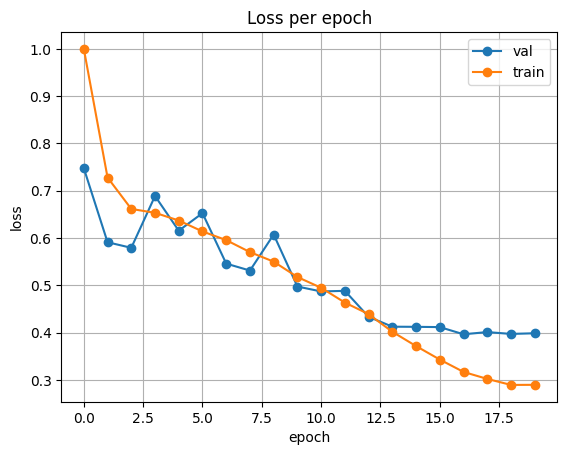

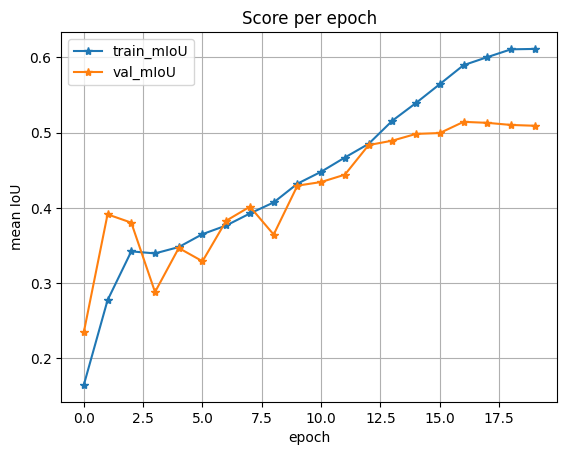

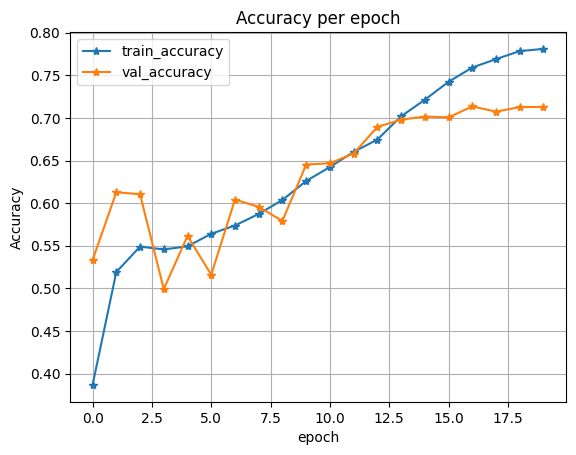

In [39]:
plot_loss(history)
plot_score(history)
plot_acc(history)

Evaluation

In [40]:
class DroneTestDataset(Dataset):

    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']

        if self.transform is None:
            img = Image.fromarray(img)

        mask = torch.from_numpy(mask).long()

        return img, mask


# t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=None)

Result

In [41]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():

        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [42]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():

        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

In [43]:
image, mask = test_set[3]
pred_mask, score = predict_image_mask_miou(model, image, mask)

In [44]:
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [45]:
mob_miou = miou_score(model, test_set)

  0%|          | 0/145 [00:00<?, ?it/s]

In [46]:
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

In [47]:
mob_acc = pixel_acc(model, test_set)

  0%|          | 0/145 [00:00<?, ?it/s]

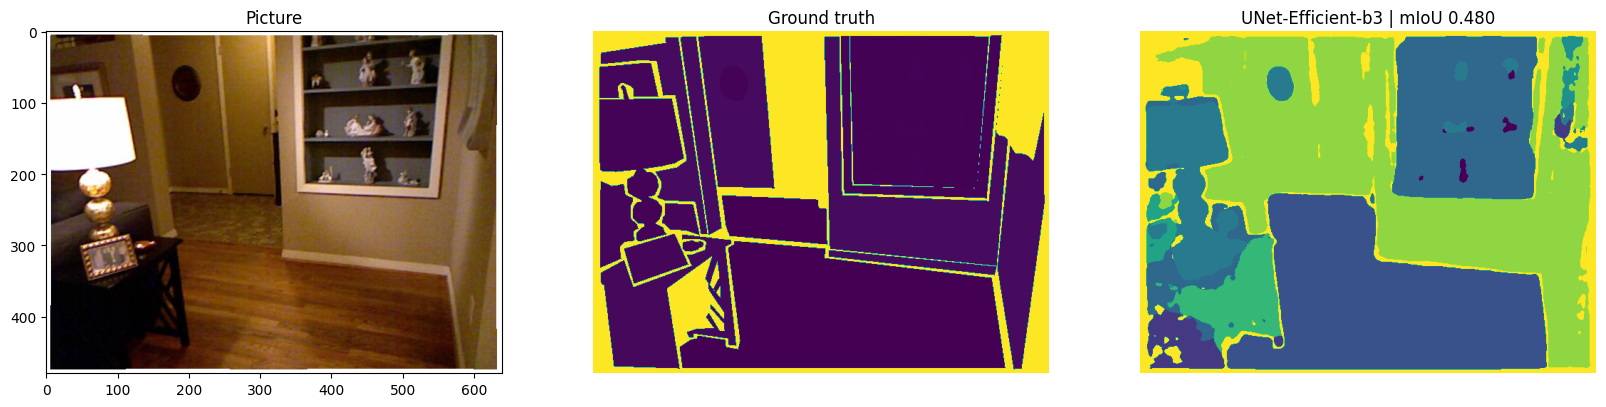

In [48]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('UNet-Efficient-b3 | mIoU {:.3f}'.format(score))
ax3.set_axis_off()

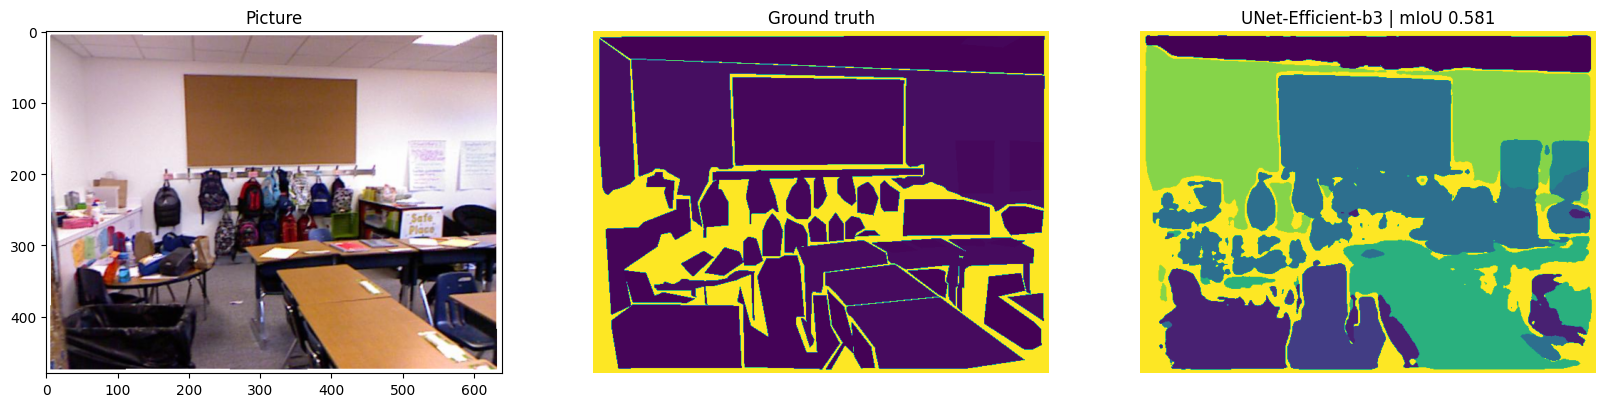

In [49]:
image2, mask2 = test_set[4]
pred_mask2, score2 = predict_image_mask_miou(model, image2, mask2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image2)
ax1.set_title('Picture');

ax2.imshow(mask2)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask2)
ax3.set_title('UNet-Efficient-b3 | mIoU {:.3f}'.format(score2))
ax3.set_axis_off()

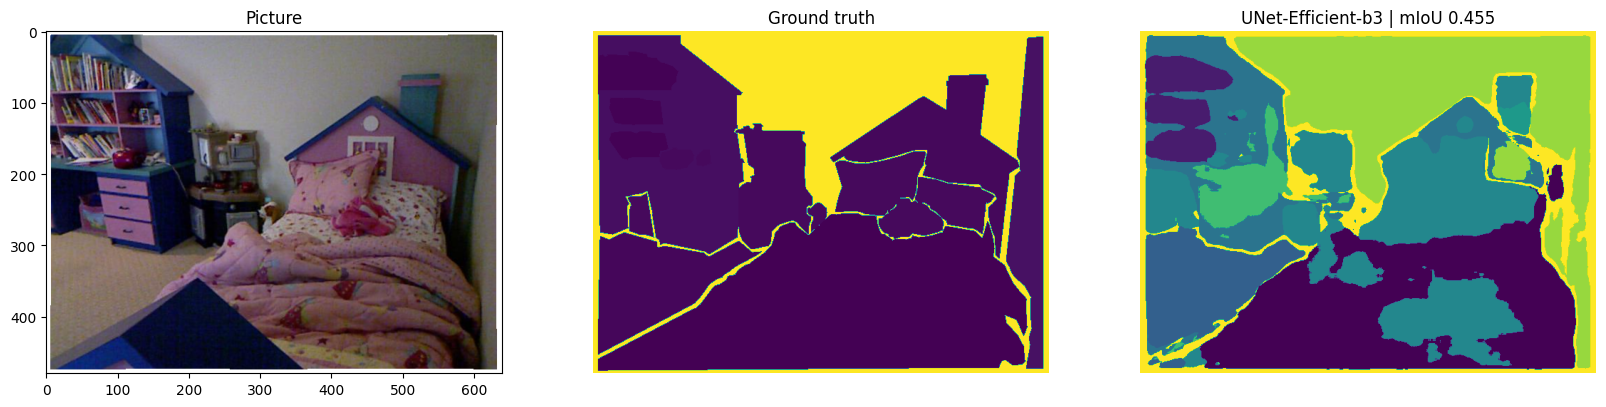

In [50]:
image3, mask3 = test_set[6]
pred_mask3, score3 = predict_image_mask_miou(model, image3, mask3)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image3)
ax1.set_title('Picture');

ax2.imshow(mask3)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask3)
ax3.set_title('UNet-Efficient-b3 | mIoU {:.3f}'.format(score3))
ax3.set_axis_off()

In [51]:
print('Test Set mIoU', np.mean(mob_miou))
print('Test Set Pixel Accuracy', np.mean(mob_acc))

Test Set mIoU 0.5323573541016662
Test Set Pixel Accuracy 0.6082336790589081


In [52]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params

72504306

In [53]:
def mean_acc(pred_mask, mask, smooth=1e-10, n_classes=14):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        acc_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                acc_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = true_label.sum().float().item()

                acc = (intersect + smooth) / (union +smooth)
                acc_per_class.append(acc)
        return np.nanmean(acc_per_class)

def predict_image_mask_mean_acc(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():

        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output = model(image)
        m_acc = mean_acc(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, m_acc

def mean_acc_classes(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_mean_acc(model, img, mask)
        accuracy.append(acc)
    return accuracy

In [54]:
m_acc_score = mean_acc_classes(model, test_set)
print(np.mean(m_acc_score))

  0%|          | 0/145 [00:00<?, ?it/s]

0.6620784165077539


In [55]:
def fw_iou(pred_mask, mask, smooth=1e-10):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)
        class_num = 14
        iou_per_class = []
        # Tính f.w. IoU cho từng lớp hoặc đối tượng
        for clas in range(0, class_num):
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(0)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                weighted = intersect * true_label.sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (weighted + smooth) / (union +smooth)
                iou_per_class.append(iou)
        total = 0
        for item in iou_per_class:
            total += item
        f_w_iou = total / float(mask.numel())
    return f_w_iou

In [56]:
def predict_image_mask_fw_iou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():

        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output = model(image)
        fw_iou_pred = fw_iou(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, fw_iou_pred

In [57]:
def fw_iou_classes(model, test_set):
    fw_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_fw_iou(model, img, mask)
        fw_iou.append(acc)
    return fw_iou

In [58]:
fw_iou_score = fw_iou_classes(model, test_set)
print(np.mean(fw_iou_score))

  0%|          | 0/145 [00:00<?, ?it/s]

0.5224860912809689


In [59]:
def dice_coef_multilabel(y_pred, y_true, num_class=14, smooth=1):
    with torch.no_grad():
        pred_mask = F.softmax(y_pred, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = y_true.contiguous().view(-1)

        dice_per_class = []
        # Tính f.w. IoU cho từng lớp hoặc đối tượng
        for clas in range(0, num_class):
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                dice_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()

                union = torch.logical_or(true_class, true_label).sum().float().item()

                dice = (2 * intersect + smooth) / (union + intersect + smooth)
                dice_per_class.append(dice)
    return dice_per_class

In [60]:
def predict_image_mask_dice_score(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():

        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output = model(image)
        dice_score_pred = dice_coef_multilabel(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, dice_score_pred

In [61]:
def dice_score_classes(model, test_set):
    dice_score = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, dice = predict_image_mask_dice_score(model, img, mask)
        dice_score.append(dice)
    return dice_score

In [62]:
dice_score_per_class = dice_score_classes(model, test_set)

  0%|          | 0/145 [00:00<?, ?it/s]

In [63]:
dice_score_classes = np.nanmean(dice_score_per_class, axis=0)

<ipython-input-63-a9b7a5ab5bbd>:1: RuntimeWarning: Mean of empty slice
  dice_score_classes = np.nanmean(dice_score_per_class, axis=0)


In [64]:
print(dice_score_classes)

[0.7710234  0.32030806 0.72095508 0.59747872 0.84749275 0.53816903
 0.52502569 0.61438265 0.50081263 0.42197239 0.4003913  0.75996441
 0.62187669        nan]


In [65]:
print(np.nanmean(dice_score_classes))

0.5876809853269083


In [66]:
   class_index = \
   {
         0: [(64, 128, 64),  'Bed'],
         1: [(192, 0, 64),  'Books'],
         2: [(0, 128, 192),  'Ceiling'],
         3: [(0, 128, 128),   'Chair'],
         4: [(128, 64, 0),    'Floor'],
         5: [(64, 64, 128),   'Furniture'],
         6: [(64, 64, 192),   'Objects'],
         7: [(192, 128, 64), 'Picture'],
         8: [(192, 192, 128),'Sofa'],
         9: [(128, 192, 128),  'Table'],
        10: [(128, 0, 192),  'TV'],
        11: [(192, 0, 192),   'Wall'],
        12: [(128, 128, 64), 'Window'],
      }

In [67]:
# Function to convert a single channel mask representation to an RGB mask.
def class_to_rgb(mask_class, class_index):

    # Create RGB channels
    r_map = np.zeros_like(mask_class).astype(np.uint8)
    g_map = np.zeros_like(mask_class).astype(np.uint8)
    b_map = np.zeros_like(mask_class).astype(np.uint8)

    # Populate RGB color channels based on the color assigned to each class.
    for class_id in range(len(class_index)):
        index = mask_class == class_id
        r_map[index] = class_index[class_id][0][0]
        g_map[index] = class_index[class_id][0][1]
        b_map[index] = class_index[class_id][0][2]

    seg_map_rgb = np.stack([r_map, g_map, b_map], axis=2)

    return seg_map_rgb

(-0.5, 639.5, 479.5, -0.5)

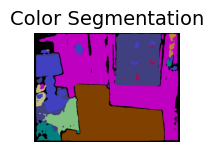

In [68]:
pred_mask_rgb = class_to_rgb(pred_mask, class_index)

plt.subplot(1,3,1)
plt.title('Color Segmentation', fontsize=14)
plt.imshow(pred_mask_rgb, cmap='gray')
plt.axis('off')

In [69]:
def plot_color_legend(class_index):

    # Extract colors and labels from class_index dictionary.
    color_array = np.array([[v[0][0], v[0][1], v[0][2]] for v in class_index.values()]).astype(np.uint8)
    class_labels = [val[1] for val in class_index.values()]

    fig, ax = plt.subplots(nrows=2, ncols=7, figsize=(15, 3))
    plt.subplots_adjust(wspace = 0.1, hspace=0.5)

    # Display color legend.
    for i, axis in enumerate(ax.flat):

        axis.imshow(color_array[i][None, None, :])
        axis.set_title(class_labels[i], fontsize = 8)
        axis.axis('off')

IndexError: index 13 is out of bounds for axis 0 with size 13

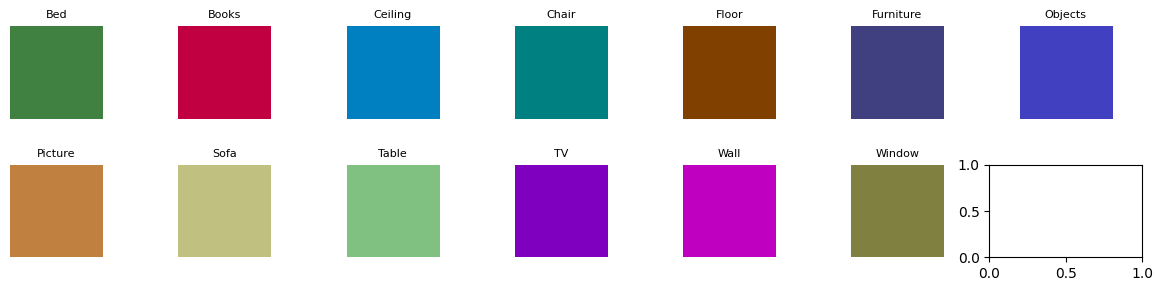

In [71]:
plot_color_legend(class_index)